Neural Style Transfer with Pytorch
============================
**Author**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Edited and extended by**: `Nikita Sokovnin`<br />

In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LfwQYvrWZT64c2rmGKKxaPP94AQ7_6hM' -O arts.zip
!unzip -q arts.zip

--2020-06-15 20:18:05--  https://docs.google.com/uc?export=download&id=1LfwQYvrWZT64c2rmGKKxaPP94AQ7_6hM
Resolving docs.google.com (docs.google.com)... 74.125.20.139, 74.125.20.138, 74.125.20.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-c4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fa4qjllovmisitbib286trid4upvhn8v/1592252250000/06538835930770314591/*/1LfwQYvrWZT64c2rmGKKxaPP94AQ7_6hM?e=download [following]
--2020-06-15 20:18:06--  https://doc-0k-c4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fa4qjllovmisitbib286trid4upvhn8v/1592252250000/06538835930770314591/*/1LfwQYvrWZT64c2rmGKKxaPP94AQ7_6hM?e=download
Resolving doc-0k-c4-docs.googleusercontent.com (doc-0k-c4-docs.googleusercontent.com)... 74.125.197.132, 2607:f8b0:400e:c03::84
Connecting to doc-0k-c4-docs.googleusercontent.com (doc-0k-c4-docs.

In [4]:
!ls 

art2.jpeg  art.jpg  arts.zip  dancing.jpg  drive  sample_data


**Image loading**

In [0]:
imsize = 512  

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("art.jpg")
style_img2 = image_loader("art2.jpeg")
content_img = image_loader("dancing.jpg")

In [7]:
device

device(type='cuda')

In [0]:
def image_to_cpu(tensor):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    return image

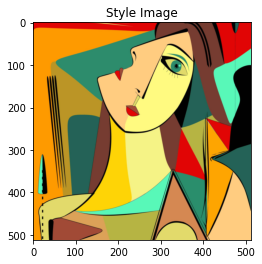

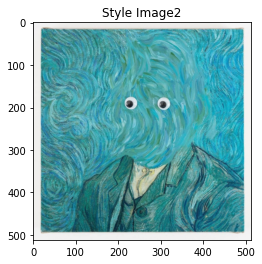

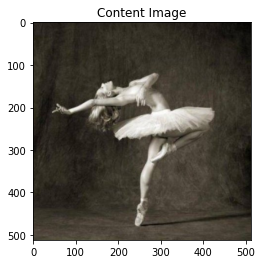

In [9]:
unloader = transforms.ToPILImage() # Tensor to image

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')

**Content and style losses**

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Gram matrix:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature, weight=1):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.weight = weight
            self.loss = self.weight * F.mse_loss(self.target, self.target) # to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = self.weight * F.mse_loss(G, self.target)
            return input

Image normalization:


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

**Model definition**

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, style_img2, content_img, 
                                   style1_weight=1, style2_weight=1,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature, style1_weight)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

                target_feature2 = model(style_img2).detach()
                style_loss2 = StyleLoss(target_feature2, style2_weight)
                model.add_module("style_loss2_{}".format(i), style_loss2)
                style_losses.append(style_loss2)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

**Definition of train loop**

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, style_img2, input_img,
                        style1_weight=1, style2_weight=1, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, style_img2, content_img,
            style1_weight, style2_weight)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()
                    imshow(input_img, title='Styled Image')

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

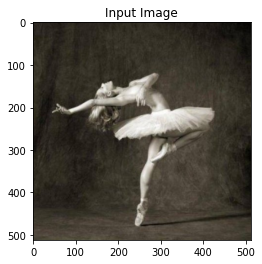

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 2287.879150 Content Loss: 17.448299



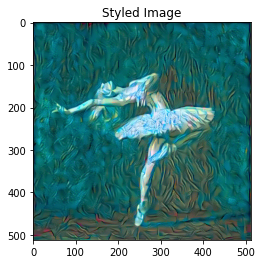

In [20]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
# Weights for each style
style1_weight=1
style2_weight=5
iterations=50
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style_img2, input_img,
                            style1_weight, style2_weight, iterations)

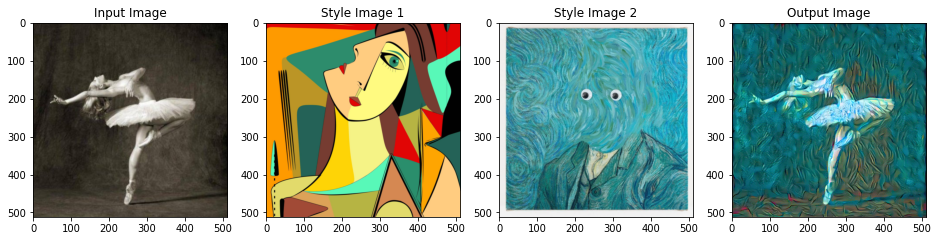

In [21]:
fig=plt.figure(figsize=(16, 16))

fig.add_subplot(1, 4, 1)
plt.imshow(image_to_cpu(content_img))
plt.title('Input Image')
fig.add_subplot(1, 4, 2)
plt.imshow(image_to_cpu(style_img))
plt.title('Style Image 1')
fig.add_subplot(1, 4, 3)
plt.imshow(image_to_cpu(style_img2))
plt.title('Style Image 2')
fig.add_subplot(1, 4, 4)
plt.imshow(image_to_cpu(output))
plt.title('Output Image')
plt.ioff()
plt.show()